In [1]:
import numpy as np
import nltk
from nltk.corpus import brown
import math
from sklearn import metrics
nltk.download("brown")
nltk.download("universal_tagset")
nltk.download("punkt")

import gensim
import gensim.downloader
from gensim.models import Word2Vec, KeyedVectors

import torch

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
import re
# def preprocess_word(word):
#   word = word.lower()
#   word = re.sub("n't","",word)
#   word = re.sub("[0-9]+","1",word)
#   return word

def remove_comma(match_obj):
    if match_obj.group(2) is not None:
        return match_obj.group(1)+match_obj.group(3)
def remove_1dash(match_obj):
    if match_obj.group(1) is not None:
        return match_obj.group(2)
def preprocess_word(w):
    w=w.lower()
    w=re.sub("n't","",w)
    w=re.sub("ed$","ing",w)
    w= re.sub(r"([a-zA-Z])(,+)([a-zA-Z])", remove_comma, w)
    w= re.sub(r"([0-9]+)([,.]+)([0-9]+)", remove_comma, w)
    w=re.sub("[0-9]+","1",w)
    w=re.sub("\$.+","$",w)
    w= re.sub(r"(1\-)(.+)", remove_1dash, w)
    return w

preprocess = np.vectorize(preprocess_word)

In [4]:
google_wv = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
google_wv.save("google_wv.wordvectors")

In [ ]:
google_wv = KeyedVectors.load("google_wv.wordvectors", mmap='r')

In [17]:
wv_mean = 0.0
wv_std = 1.0
dim_wv = 300

In [18]:
def get_wv(word):
  if word == None:
    wv = torch.zeros(dim_wv)
    return wv
  word = preprocess_word(word)
  if word in google_wv:
    wv = torch.tensor(google_wv[word])
  else:
    wv = torch.normal(wv_mean, wv_std, (dim_wv,))
  return wv

In [19]:
class FFNN(torch.nn.Module):
  def __init__(self):
    super(FFNN, self).__init__()
    n_hidden = 100
    n_hidden2 = 50
    self.first = torch.nn.Linear(dim_wv*3, n_hidden)
    self.second = torch.nn.Linear(n_hidden, n_hidden2)
    self.third = torch.nn.Linear(n_hidden2, 12)
  def forward(self, X):
    relu = torch.nn.functional.relu
    X = self.third(relu(self.second(relu(self.first(X)))))
    X = torch.nn.functional.softmax(X, dim=1)
    return X

In [42]:
class POS_tagger:
  def __init__(self, train_sentences):
    self.sentences = train_sentences

    self.tagset = np.array([ '.' , 'ADJ' , 'ADP' , 'ADV' , 'CONJ' , 'DET' , 'NOUN' , 'NUM' , 'PRON' , 'PRT' , 'VERB' , 'X' ])
    self.tag_to_id = dict(zip(self.tagset, np.arange(12)))

    self.ffnn = None

  def train(self):

    n_epochs = 3
    batch_size = 64

    n_total = int(np.ceil(len(self.sentences)/batch_size))

    self.ffnn = FFNN()
    optimizer = torch.optim.Adam(self.ffnn.parameters(), lr=0.01)
    
    for epoch in range(n_epochs):
      for batch in range(n_total):
        sentences = self.sentences[batch*batch_size: min((batch+1)*batch_size, len(self.sentences))]

        triples = []  # [ ... (prev_word, current_word, next_word, current_tag) ... ]
        for i in range(len(sentences)):
          sent = sentences[i]
          prev = None
          for j in range(len(sent)):
            word = sent[j][0]  # word
            tag = sent[j][1]   # tag
            if tag == '.':  # trying something
              continue
            if j == len(sent)-1:
              next = None
            else:
              next = sent[j+1][0]
            triples.append((prev, word, next, tag))
            prev = word

        N = len(triples)
        X_train = torch.zeros((N, 3*dim_wv))
        Y_true = torch.zeros((N, 12))

        for i in range(N):
          triple = triples[i]
          Y_true[i][self.tag_to_id[triple[3]]] = 1
          X_train[i][0:dim_wv] = get_wv(triple[0])
          X_train[i][dim_wv:2*dim_wv] = get_wv(triple[1])
          X_train[i][2*dim_wv:3*dim_wv] = get_wv(triple[2])
        
        optimizer.zero_grad()
        prediction = self.ffnn(X_train)
        # prediction = 1e-16 + torch.nn.functional.relu(prediction - 1e-16) # temporary try
        prediction = 1e-16 + prediction # temporary try
        loss = (-Y_true*torch.log(prediction)).sum(axis = 1).mean(axis = 0)
        loss.backward()
        optimizer.step()

        # if batch%10 == 0:
        #   print(f"epoch {epoch} batch {batch} loss: {loss}")

  def tag(self,sentence):
    sentence = np.array(sentence, dtype="object")
    sentence = preprocess(sentence)

    # X = torch.zeros(3*dim_wv)

    triples = []  # [ ... (prev_word, current_word, next_word) ... ]
    non_punc_indices = []   # trying something
    prev = None
    for j in range(len(sentence)):
      word = sentence[j]
      if word in ['!', "'", "''", '(', ')', ',', '--', '.', ':', ';', '?', '[', ']','``']:
        continue
      else:
        non_punc_indices.append(j)
      if j == len(sentence)-1:
        next = None
      else:
        next = sentence[j+1][0]
      triples.append((prev, word, next))
      prev = word

    N = len(triples)
    X_test = torch.zeros((N, 3*dim_wv))
    Y_pred = torch.zeros((N, 12))

    for i in range(N):
      triple = triples[i]
      X_test[i][0:dim_wv] = get_wv(triple[0])
      X_test[i][dim_wv:2*dim_wv] = get_wv(triple[1])
      X_test[i][2*dim_wv:3*dim_wv] = get_wv(triple[2])
    
    Y_pred = self.ffnn(X_test)

    tag_id = torch.argmax(Y_pred, dim = 1).numpy()
    # tag_id[tag_id > 11] = 11
    tags = self.tagset[tag_id]

    tagged_sentence = np.array([[word,"."] for word in sentence], dtype="object")   # trying something
    tagged_sentence[non_punc_indices,1] = tags  # trying something
    return tagged_sentence

In [9]:
frac = 0.8
all_sentences = np.array(brown.tagged_sents(tagset="universal"), dtype="object")
n_total = len(all_sentences)
n_train = math.floor(n_total*frac)

indices = np.arange(n_total)
np.random.shuffle(indices)

train_sents = all_sentences[ indices[ : n_train] ]
val_sents = all_sentences[ indices[n_train : ] ]

In [34]:
myTagger = POS_tagger(train_sents)

In [35]:
myTagger.train()

epoch 0 batch 0 loss: 2.5408716201782227
epoch 0 batch 10 loss: 1.6911442279815674
epoch 0 batch 20 loss: 1.3901417255401611
epoch 0 batch 30 loss: 1.2381165027618408
epoch 0 batch 40 loss: 1.0889995098114014
epoch 0 batch 50 loss: 0.9424164891242981
epoch 0 batch 60 loss: 0.8102530241012573
epoch 0 batch 70 loss: 0.8069498538970947
epoch 0 batch 80 loss: 0.678210437297821
epoch 0 batch 90 loss: 0.6591576337814331
epoch 0 batch 100 loss: 0.8086625933647156
epoch 0 batch 110 loss: 0.5885439515113831
epoch 0 batch 120 loss: 0.6416041254997253
epoch 0 batch 130 loss: 0.5660372972488403
epoch 0 batch 140 loss: 0.6161980628967285
epoch 0 batch 150 loss: 0.5786646008491516
epoch 0 batch 160 loss: 0.503699779510498
epoch 0 batch 170 loss: 0.5665093064308167
epoch 0 batch 180 loss: 0.533111035823822
epoch 0 batch 190 loss: 0.5524552464485168
epoch 0 batch 200 loss: 0.4925937354564667
epoch 0 batch 210 loss: 0.5066068768501282
epoch 0 batch 220 loss: 0.44994407892227173
epoch 0 batch 230 loss: 

In [36]:
def tag(sentence):  # sentence as a string
  sentence = nltk.tokenize.word_tokenize(sentence)
  tags = myTagger.tag(sentence)[:,1]
  return list(zip(sentence, tags))

tag("I left my phone on the left side of the room")

[('I', 'PRON'),
 ('left', 'VERB'),
 ('my', 'DET'),
 ('phone', 'NOUN'),
 ('on', 'ADP'),
 ('the', 'DET'),
 ('left', 'VERB'),
 ('side', 'NOUN'),
 ('of', 'CONJ'),
 ('the', 'DET'),
 ('room', 'NOUN')]

In [37]:
pred = []
true = []
for sentence in val_sents:
  sentence = np.array(sentence)
  true = true + list(sentence[:,1])
  if len(sentence) == 1:
    pred = pred + ["."]
  else:
    pred = pred + list(myTagger.tag(sentence[:,0])[:,1])

In [38]:
print(metrics.classification_report(true, pred, digits=4))

              precision    recall  f1-score   support

           .     0.9990    1.0000    0.9995     29856
         ADJ     0.8926    0.8016    0.8446     16862
         ADP     0.8051    0.8031    0.8041     29302
         ADV     0.8952    0.8215    0.8568     11437
        CONJ     0.4501    0.5711    0.5034      7652
         DET     0.9541    0.8414    0.8942     27840
        NOUN     0.8141    0.9441    0.8743     55616
         NUM     0.9634    0.9222    0.9424      2944
        PRON     0.9507    0.9771    0.9637      9924
         PRT     0.7893    0.3597    0.4942      6050
        VERB     0.9644    0.9241    0.9439     36946
           X     0.6667    0.0627    0.1146       287

    accuracy                         0.8749    234716
   macro avg     0.8454    0.7524    0.7696    234716
weighted avg     0.8813    0.8749    0.8736    234716



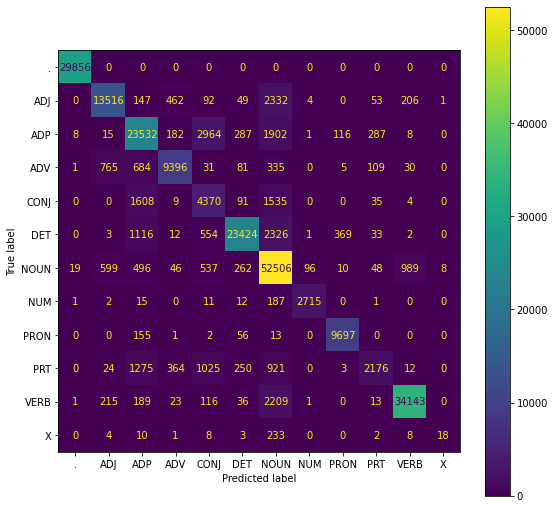

In [39]:
# cm = metrics.confusion_matrix(true,pred)
# print(cm)
# metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = preprocess(myTagger.tagset)).plot(include_values = False)
disp = metrics.ConfusionMatrixDisplay.from_predictions( true, pred, labels=myTagger.tagset, display_labels=myTagger.tagset, values_format='') 
fig = disp.ax_.get_figure() 
fig.set_figwidth(9)
fig.set_figheight(9)  

In [44]:
frac = 0.2
all_sentences = np.array(brown.tagged_sents(tagset="universal"), dtype="object")
n_total = len(all_sentences)
n_val = math.floor(n_total*frac)

indices = np.arange(n_total)
np.random.shuffle(indices)

cross_valdation_accuracies = np.zeros(5)

for k in range(5):
  tmp = np.floor(np.arange(n_total)/n_val)
  train_ids = indices[ tmp != k ]
  val_ids = indices[ tmp == k ]
  
  train_sents = all_sentences[ train_ids ]
  val_sents = all_sentences[ val_ids ]

  myTagger = POS_tagger(train_sents)
  myTagger.train()

  pred = []
  true = []
  for sentence in val_sents:
    sentence = np.array(sentence)
    true = true + list(sentence[:,1])
    if len(sentence) == 1:
      pred = pred + ["."]
    else:
      pred = pred + list(myTagger.tag(sentence[:,0])[:,1])

  from sklearn import metrics
  cm = metrics.confusion_matrix(true,pred)

  cross_valdation_accuracies[k] = np.trace(cm)/np.sum(cm)

In [45]:
print(cross_valdation_accuracies)
print(cross_valdation_accuracies.mean())

[0.87424327 0.88046814 0.87572933 0.87561314 0.8739502 ]
0.876000814821843
